# Plotting FWI for 2022 for ESOTC

<div class="alert alert-block alert-info">
<b>Note:</b> If you're running this notebook on ATOS using ecinteractive, make sure that you started it with at least 16 GB ram memory, otherwise it will crash at some point.
</div>

In this notebook we calculate and plot the diffrence between number of days when FWI>50 in 2022 and mean number in 1991-2022 climatology.  

At the moment reading of the data is hardcoded, as the files are in Chris' scratch directory.  

First import bunch of stuff:

In [15]:
import xarray as xr
import cartopy as cart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 25})

In [2]:
small = xr.open_mfdataset('/scratch/maca/geff-grib-issue/reg_fwi.nc')

I was running out of memory, so for the first go, I slice it to smaller area.   
This is now commented out.  
If you don't have enough memory and still want to run this data, replace small with ds in the previous cell and uncomment next cell.

In [3]:
#small = ds.sel(latitude=slice(50,35), longitude=slice(10,30))

In [4]:
fwinx = small.fwinx

In [5]:
ref_fwi = 50

# The calculations

First we filter out the time period we want to analyse. Here it is from 1st May 2022 to 30 September 2022.

In [6]:
last_y = small.sel(time=slice('2022-05-01T12:00:00.000000000','2022-09-30T12:00:00.000000000'))
last_y

<xarray.Dataset>
Dimensions:    (latitude: 214, longitude: 302, time: 153)
Coordinates:
  * longitude  (longitude) float32 -34.88 -34.59 -34.31 ... 49.22 49.5 49.78
  * latitude   (latitude) float32 79.95 79.67 79.39 79.11 ... 20.66 20.37 20.09
  * time       (time) datetime64[ns] 2022-05-01T12:00:00 ... 2022-09-30T12:00:00
Data variables:
    fwinx      (time, latitude, longitude) float32 dask.array<chunksize=(153, 214, 302), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-30 16:22:07 GMT by grib_to_netcdf-2.30.0: grib_to_n...

Next we calculate the number of days where FWI>50

In [7]:
fwi_over50_2022 = last_y.fwinx.where(last_y.fwinx>50).groupby('time.year').count(dim='time')
fwi_over50_2022

<xarray.DataArray 'fwinx' (year: 1, latitude: 214, longitude: 302)>
dask.array<stack, shape=(1, 214, 302), dtype=int64, chunksize=(1, 214, 302), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -34.88 -34.59 -34.31 ... 49.22 49.5 49.78
  * latitude   (latitude) float32 79.95 79.67 79.39 79.11 ... 20.66 20.37 20.09
  * year       (year) int64 2022

We need to do the same for the climatological data.  
First we filter the May-September period for 1991 and calculate the number of days where FWI>50.  
We repeat that for all the years and concatenate all the years.

In [8]:
fwi_data_summer = small.sel(time=slice('1991-05-01', '1991-09-30'))
fwi_over50 = fwi_data_summer.fwinx.where(fwi_data_summer.fwinx>50).groupby('time.year').count(dim='time')
for year in range(1992,2021):
    fwi_data = small.sel(time=slice(f'{year}-05-01', f'{year}-09-30'))
    x = fwi_data.fwinx.where(fwi_data.fwinx>50).groupby('time.year').count(dim='time')
    fwi_over50 = xr.concat([fwi_over50, x], dim='year')
fwi_over50

<xarray.DataArray 'fwinx' (year: 30, latitude: 214, longitude: 302)>
dask.array<concatenate, shape=(30, 214, 302), dtype=int64, chunksize=(1, 214, 302), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -34.88 -34.59 -34.31 ... 49.22 49.5 49.78
  * latitude   (latitude) float32 79.95 79.67 79.39 79.11 ... 20.66 20.37 20.09
  * year       (year) int64 1991 1992 1993 1994 1995 ... 2017 2018 2019 2020

Now we can calucate average number of days when FWI>50

In [9]:
fwi_over50_mean = fwi_over50.mean(dim='year')
fwi_over50_mean

<xarray.DataArray 'fwinx' (latitude: 214, longitude: 302)>
dask.array<mean_agg-aggregate, shape=(214, 302), dtype=float64, chunksize=(214, 302), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -34.88 -34.59 -34.31 ... 49.22 49.5 49.78
  * latitude   (latitude) float32 79.95 79.67 79.39 79.11 ... 20.66 20.37 20.09

And the anomaly is the difference between these two.  
The 2022 data has year as dimension, so we need to remove it by selecting it beforwe we can calculate the difference.

In [10]:
anom = fwi_over50_2022.sel(year=2022) - fwi_over50_mean
anom

<xarray.DataArray 'fwinx' (latitude: 214, longitude: 302)>
dask.array<sub, shape=(214, 302), dtype=float64, chunksize=(214, 302), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -34.88 -34.59 -34.31 ... 49.22 49.5 49.78
  * latitude   (latitude) float32 79.95 79.67 79.39 79.11 ... 20.66 20.37 20.09
    year       int64 2022

## Plotting

<ipython-input-20-0327036584b4>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator(32))


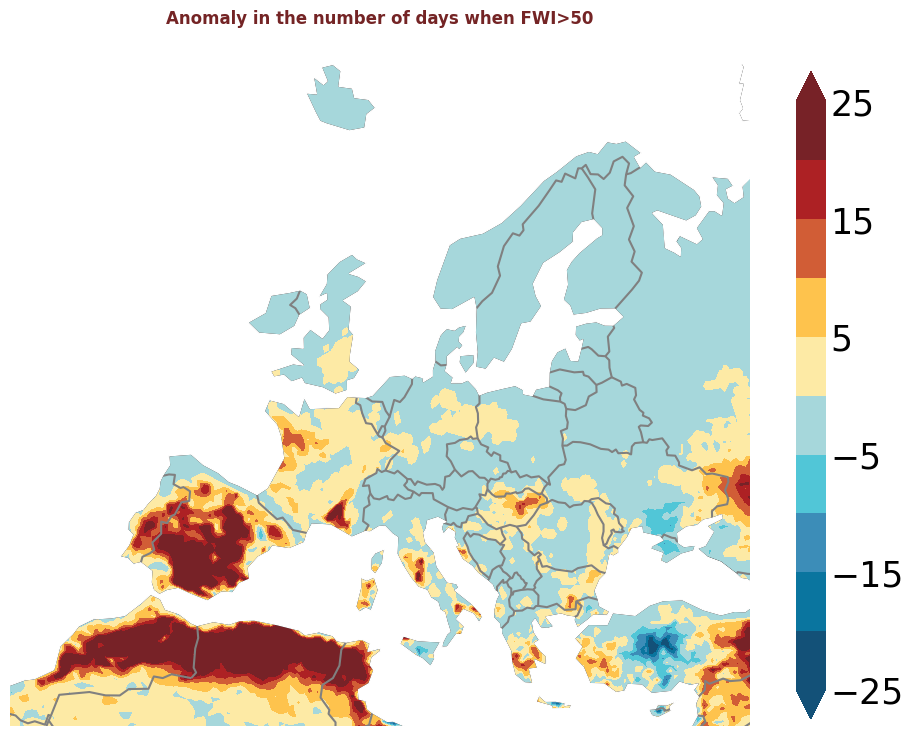

In [20]:
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.TransverseMercator(32))

ax.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='#dc5736', color='white')
ax.add_feature(cart.feature.BORDERS, edgecolor='grey', lw=1.5)
ax.set_extent ((-15, 40, 34, 70), ccrs.PlateCarree())

redblue = ['#135178', '#0a759f', '#3c8db8', '#51c6d7', '#a6d7db', '#fdeaa5', '#fec34d', '#d15d36', '#ad2124', '#772227']
# Create the custom colormap
my_cmap = (colors.ListedColormap(redblue))
my_cmap.set_over('#772227')
my_cmap.set_under('#135178')

# Specify the number of discrete levels to use in the colormap
bounds = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]
norm = colors.BoundaryNorm(bounds, my_cmap.N)

# Plot data with contours and shading
img = anom.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap=my_cmap, norm=norm, levels=11, extend='both',
                         add_colorbar=False, add_labels=False)
cbar = plt.colorbar(img, ax=ax, shrink=0.7, ticks=bounds[::2] )
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)

#Add coastlines and title, remove black frame
ax.coastlines()
ax.set_frame_on(False)
plt.title("Anomaly in the number of days when FWI>50", fontsize=12, fontweight='bold', y=1.05, color='#742425')
plt.tight_layout()
plt.savefig('/home/nen/scripts/ESOTC/2022/fwi_anom_europe_v_nowhite.tiff', format='tiff',facecolor='white')

And here is the code for the version with white values between -1 and 1.

<ipython-input-18-61ea918e51a6>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator(32))


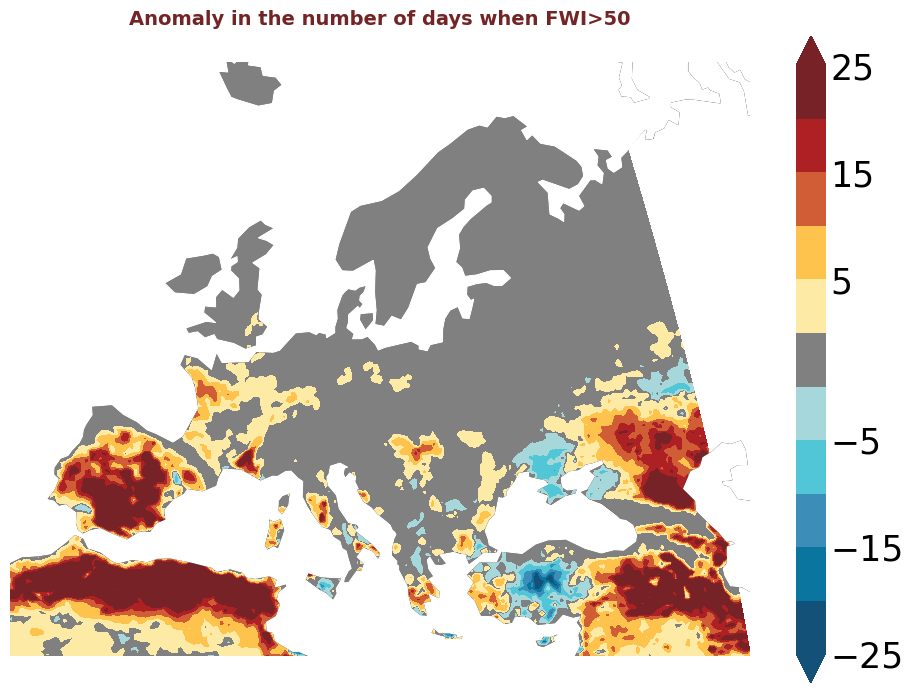

In [18]:
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.TransverseMercator(32))

ax.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='#dc5736', color='white')
ax.set_extent ((-10, 50, 34, 70), ccrs.PlateCarree())
redblue = ['#135178', '#0a759f', '#3c8db8', '#51c6d7', '#a6d7db','grey', '#fdeaa5', '#fec34d', '#d15d36', '#ad2124', '#772227']
# Create the custom colormap
my_cmap = (colors.ListedColormap(redblue))
my_cmap.set_over('#772227')
my_cmap.set_under('#135178')



# Specify the number of discrete levels to use in the colormap
bounds = [-25, -20, -15, -10, -5, -1, 1, 5, 10, 15, 20, 25]
norm = colors.BoundaryNorm(bounds, my_cmap.N)

# Plot data with contours and shading
img = anom.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap=my_cmap, norm=norm, levels=11, extend='both',
                         add_colorbar=False, add_labels=False)
cbar = plt.colorbar(img, ax=ax, shrink=0.7, ticks=[-25, -15, -5, 5, 15, 25] )
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)

#Add coastlines and title, remove black frame
ax.coastlines()
ax.set_frame_on(False)
plt.title("Anomaly in the number of days when FWI>50", fontsize=14, fontweight='bold', y=1.05, color='#742425')
plt.tight_layout()
plt.savefig('/home/nen/scripts/ESOTC/2022/fwi_anom_europe_with_white.png',facecolor='white')